# Exploring the Lorenz System of Differential Equations

In this Notebook we explore the Lorenz system of differential equations:

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

This is one of the classic systems in non-linear differential equations. It exhibits a range of different behaviors as the parameters ($\sigma$, $\beta$, $\rho$) are varied.

## Imports

First, we import the needed things from IPython, NumPy, Matplotlib and SciPy.

In [1]:
%matplotlib inline

In [2]:
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

In [3]:
import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

## Computing the trajectories and plotting the result

We define a function that can integrate the differential equations numerically and then plot the solutions. This function has arguments that control the parameters of the differential equation ($\sigma$, $\beta$, $\rho$), the numerical integration (`N`, `max_time`) and the visualization (`angle`).

In [27]:
def solve_lorenz(N=10, angle=0.0, max_time=10.0, sigma=10.0, beta=8./3, rho=28.0):

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    
    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])
    
    # choose a different color for each trajectory
    colors = plt.cm.jet(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)
    plt.show()

    return t, x_t

Let's call the function once to view the solutions. For this set of parameters, we see the trajectories swirling around two points, called attractors. 

In [34]:
t, x_t = solve_lorenz(angle=0, N=10)

Using IPython's `interactive` function, we can explore how the trajectories behave as we change the various parameters.

In [8]:
w = interactive(solve_lorenz, angle=(0.,360.), N=(0,50), sigma=(0.0,50.0), rho=(0.0,50.0))
display(w)

interactive(children=(IntSlider(value=10, description='N', max=50), FloatSlider(value=0.0, description='angle'…

The object returned by `interactive` is a `Widget` object and it has attributes that contain the current result and arguments:

In [29]:
t, x_t = w.result
x_t.shape

(10, 1000, 3)

In [35]:
#compute derivative 

def lorenz_deriv(x_y_z, sigma=10.0, beta=8./3, rho=28.0):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

x_dot = np.zeros((x_t.shape[1],x_t.shape[2]))

for i in range(x_t.shape[1]):

  x_dot[i,:] = lorenz_deriv(x_t[1,i,:])

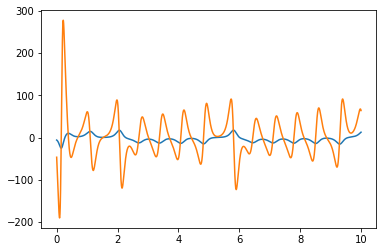

In [36]:
plt.plot(t,x_t[1,:,0])
plt.plot(t,x_dot[:,0])

In [37]:
#generate polinomial combination 

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

Theta = poly.fit_transform(x_t[1,:,:])

In [49]:
from sklearn.linear_model import Lasso

Lrz = Lasso(alpha=10)

Lrz.fit(Theta,x_dot)

Lasso(alpha=10)

In [50]:
Lrz.coef_[1]

array([ 0.00000000e+00,  2.12825222e+01,  1.90574203e+00, -0.00000000e+00,
        1.02146464e-01, -6.62149209e-02, -8.34053109e-01,  9.98147713e-03,
       -5.61294888e-02, -5.53486928e-03])

In [51]:
Lrz.score(Theta,x_dot)

0.989481194237059

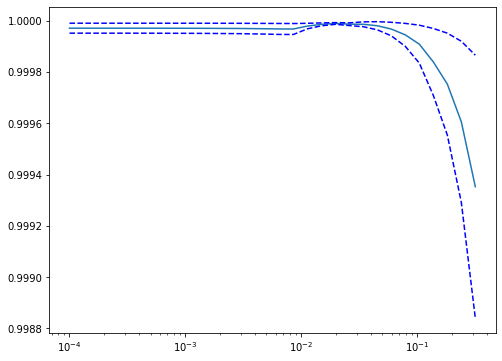

In [52]:
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(Theta, x_dot)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")


In [64]:
#lasso_ = Lasso(alpha=clf.best_params_['alpha'],random_state=0, max_iter=10000)
lasso_ = Lasso(alpha=1000,random_state=0, max_iter=10000)
lasso_.fit(Theta,x_dot)

Lasso(alpha=1000, max_iter=10000, random_state=0)

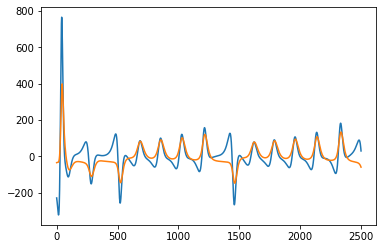

In [65]:
plt.plot(x_dot[:,1])
plt.plot(lasso_.predict(Theta)[:,1])